# Transmission matrix for optical branched flows

In [1]:
import os
from scipy import *
from numpy import *
from pylab import *
import arrayfire as af
from core_libs.bindings import *
from core_libs.af_loader import *
from numba import njit, prange
from matplotlib.colors import LightSource
import umap
%matplotlib notebook

## Start a simulation mesh
Define the simulation box parameters

In [2]:
#number of transversal dimensions (only working 1 and 2, necessary for plotting)
dims = 1

#Number of points in x,y transversal dimensions
Nx = 1024
Ny = 1

#do not change Nt, Nz
Nt = 1 
Nz = 1

#spatial steps
dx = .2
dy = .2
dt = 1.

#integration parameters

total_steps = 100
stride = 100
dz = 0.03


##generate random points for centering gaussians######
######################################################
######################################################

def distance(x1, y1, x2, y2):
    dsq = (x1 - x2) ** 2 + (y1 - y2) ** 2
    d = np.sqrt(dsq)
    return d


circle_list = []
n=1500

lim_x = Nx*dx
lim_z = dz*total_steps*stride

random.seed(10)
while len(circle_list) < n:
    
    r = random.randint(1., 7)
    x = random.randint(r, lim_x - r)
    y = random.randint(lim_z/20, lim_z)

    collide = False

#     for x2, y2, r2 in circle_list:
#         d = distance(x, y, x2, y2)
#         if 4*d < r + r2:
#             collide = True
#             break

    if not collide:
        circle_list.append((x, y, r))
        

######################################################
######################################################33



In [3]:
#Construct a vector V(x,z) to feed to the solver

x = np.linspace(0,lim_x,Nx)
z = np.linspace(0,lim_z,2048)
xx, zz = meshgrid(x,z,indexing='ij')
vector = np.zeros(xx.shape)
    
@njit(parallel=True)
def construct(vector, circle_list):
    for i in range(0,len(circle_list)):
        #print(i, ' ', len(circle_list),end='\r')
        x0,z0,r = circle_list[i][0],circle_list[i][1],circle_list[i][2]
        #vector += (((xx-x0)*(xx-x0) + (yy-y0)*(yy-y0))<r**2)
        m=1.2
        vector += np.exp(-2*((xx-x0)**2 + (zz-z0)**2)**m/(r**(2*m)))

    return vector

vector = construct(vector, circle_list)
subplots()
imshow(np.transpose(vector),extent=[0,lim_x,0,lim_z],aspect=1)
colorbar()

C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\numba\core\ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'circle_list' of function 'construct'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-3-5cf77415a7e8>", line 9:
@njit(parallel=True)
def construct(vector, circle_list):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\numba\np\ufunc\parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled.
  warnings.warn(problem)


<IPython.core.display.Javascript object>

In [5]:
def gaussian_1d_field(x,x0,A,w):
    new_field = A*np.exp(-((x-x0)*(x-x0))/(2*w*w))

    return new_field

scalings = [0.1]
for scaling in scalings:
    #cycle for each center position for a gaussian between Nx/3 - 2*Nx/3
    for i in range(int(Nx/3),int(2*Nx/3),10):
        print(i)
        saveDir = "transmission_matrix/scaling"+str(round(scaling*100))+'/'+str(i)
        use_V_xz = 1
        my_simulation = simulation_config(dims, Nx, Ny, Nt, Nz, total_steps, 
                                          stride,dx,dy,dz,dt, 0,0, use_V_xz, saveDir)

        #center position
        x0 = i*dx
        print('******************',x0,'******************')
        
        #

        w = 6
        A = 1.
        profile_array = gaussian_1d_field(my_simulation.x_np,x0,A,w)
        
        my_simulation.initial_condition.add_field(af.interop.from_ndarray(profile_array))

        #how many nonlinear numbers
        number_nl_numbers = 1
        #(g, power)
        nl_numbers = [nonlinear_number(.0,2)]


        #define the nonlinearities of type vector
        # absorbing boundaries
        number_nl_vectors = 1
        nl_vec_0 = nonlinear_vector(my_simulation,0)
        nl_vec_0.add_field(af.interop.from_ndarray(gaussian_1d_field(my_simulation.x_af,0,10.j,w)))
        nl_vec_0.add_field(af.interop.from_ndarray(gaussian_1d_field(my_simulation.x_af,Nx*dx,10.j,w)))

        #define the nonlinearities to pass
        nl_vectors = [nl_vec_0]

        #update the simulation config file
        my_simulation.number_nl_numbers = number_nl_numbers
        my_simulation.number_nl_vectors = number_nl_vectors
        
        my_simulation.gen_config_file(nl_numbers,nl_vectors)

        #create the potential V(x,z) distribution
        vz_dist = vz_distribution(my_simulation,0,2048)
        vector1 = vector.reshape((Nx,1,1,2048))
        vector1 = scaling*vector1

        vvv = af.interop.from_ndarray(vector1)
        vz_dist.add_field(vvv)
        vz_dist.save_field(0)

        #%%cmd
        !hibpm_run.exe 2 0

341
****************** 68.2 ******************
**Configuring Mesh:
Config folder already exists, skipping mkdir
Configuration file created!
**Configuring Initial Conditions
Initial condition file created!
**Configuring nonlinearities:
Nonlinearities configuration files created!
351
****************** 70.2 ******************
**Configuring Mesh:
Config folder already exists, skipping mkdir
Configuration file created!
**Configuring Initial Conditions
Initial condition file created!
**Configuring nonlinearities:
Nonlinearities configuration files created!
361
****************** 72.2 ******************
**Configuring Mesh:
Config folder already exists, skipping mkdir
Configuration file created!
**Configuring Initial Conditions
Initial condition file created!
**Configuring nonlinearities:
Nonlinearities configuration files created!
371
****************** 74.2 ******************
**Configuring Mesh:
Config folder already exists, skipping mkdir
Configuration file created!
**Configuring Initial C

641
****************** 128.20000000000002 ******************
**Configuring Mesh:
Config folder already exists, skipping mkdir
Configuration file created!
**Configuring Initial Conditions
Initial condition file created!
**Configuring nonlinearities:
Nonlinearities configuration files created!
651
****************** 130.20000000000002 ******************
**Configuring Mesh:
Config folder already exists, skipping mkdir
Configuration file created!
**Configuring Initial Conditions
Initial condition file created!
**Configuring nonlinearities:
Nonlinearities configuration files created!
661
****************** 132.20000000000002 ******************
**Configuring Mesh:
Config folder already exists, skipping mkdir
Configuration file created!
**Configuring Initial Conditions
Initial condition file created!
**Configuring nonlinearities:
Nonlinearities configuration files created!
671
****************** 134.20000000000002 ******************
**Configuring Mesh:
Config folder already exists, skipping m

In [6]:
list_of_files = []
for scaling in scalings:
    sc = str(round(scaling*100))
    saveDir = 'transmission_matrix/scaling'+sc+'/341/'
    rr = saveDir.split('/')[:-1][0]+'/'+saveDir.split('/')[:-1][1]+'/'
    lista_total = [[rr+f,f] for f in os.listdir(rr)]
    list_of_files.append(lista_total)

In [7]:
#load the simulation mesh
my_mesh = mesh(saveDir+"/")

#load the data from data folder
#stride between consecutive loaded files
all_outputs = []
all_data_out = []
all_data_in = []
all_pixel_in = []
all_top_view = []

#line to consider as output
output_index = 30

for j in range(0,len(list_of_files)):
    output = []
    top_view = []
    lista_total = list_of_files[j]
    for i in range(0,len(lista_total)):
        stride_read = 1
        simulation_data,zs = load_data_folder(lista_total[i][0]+"/gnlse_field/",my_mesh,stride_read)
        output.append([simulation_data[output_index],simulation_data[0],int(lista_total[i][1])])
        top_view.append(simulation_data)
    output = np.array(output)
    output = output[output[:, 2].argsort()]
    data_out = output[:,0]
    data_in = output[:,1]
    pixel_in = output[:,2]
    all_outputs.append(output)
    all_data_out.append(data_out)
    all_data_in.append(data_in)
    all_pixel_in.append(pixel_in)
    all_top_view.append(top_view)



C:\Users\nunoa\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [8]:
simulation_data,zs = load_data_folder(saveDir+"/gnlse_field/",my_mesh,stride_read)

<IPython.core.display.Javascript object>


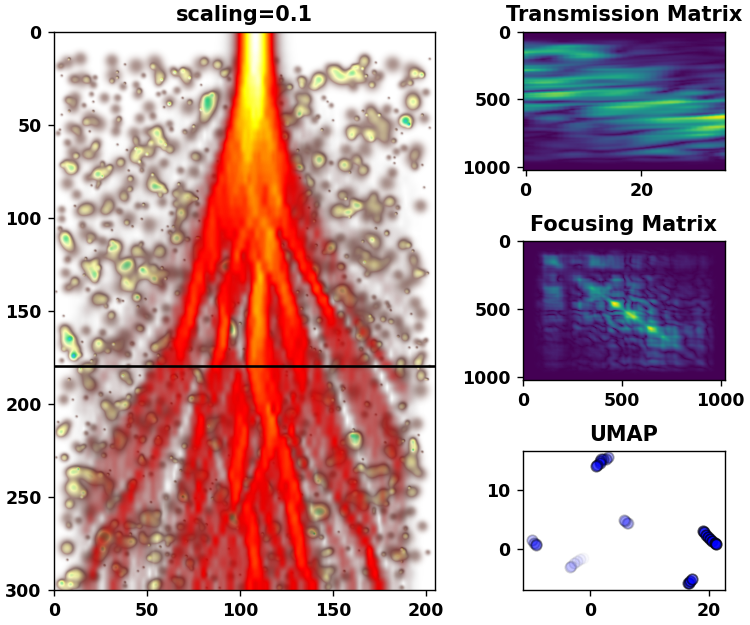

In [13]:
# O = M * I
fig = figure(constrained_layout=True,figsize=[6,5])
gs = GridSpec(3, 2, figure=fig,width_ratios=[2,1])
Ms=[]

for j in range(0,len(list_of_files)):
    
    output = all_outputs[j]
    data_out = all_data_out[j]
    data_in = all_data_in[j]
    pixel_in = all_pixel_in[j]
    
    i1 = 0
    i2 = len(data_out)
    matrix = []
    new_pixels = []
    new_data_in = []
    step = 1 #superpixel step 
    for i in range(i1,i2,step):
        matrix.append(np.sum(data_out[i:i+step]))
        new_data_in.append(np.sum(data_in[i:i+step]))
        new_pixels.append(np.sum(pixel_in[i:i+step]))

    new_data_in = np.array(new_data_in)
    new_pixels = np.array(new_pixels)

    M = np.transpose(matrix)
    N = np.transpose(new_data_in)
    ax1 = fig.add_subplot(gs[:, 0])
    
    ax1.set_title('scaling='+str(scalings[j]))
    ls = LightSource(azdeg=210, altdeg=45)
    rgb = ls.shade(np.transpose(vector1[:,0,0,:]), cmap=cm.terrain_r, vert_exag=1, blend_mode='overlay')
    ax1.imshow(rgb, extent = [0,Nx*dx, zs[-1],0],alpha=0.8,aspect='auto')
    sim_data = all_top_view[j][20]
    ax1.imshow(np.abs(sim_data), alpha = 3*np.abs(sim_data)/np.max(np.abs(sim_data)), 
           extent=[0,Nx*dx, zs[-1],0],cmap=cm.hot,aspect=1)
    
    ax1.axhline(zs[output_index],color='k')
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title('Transmission Matrix')
    ax2.imshow(np.abs(M),aspect='auto')
    
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.set_title('Focusing Matrix')
    ax3.imshow(np.abs(np.dot(M,np.conjugate(np.transpose(M)))),aspect='auto', interpolation='none')
    
    Ms.append(M)
    
    
    n_neighbors=2
    min_dist=0.2
    n_components=2
    metric='l2'

    from sklearn.preprocessing import StandardScaler, minmax_scale
    #scaler = StandardScaler()
    #scaler.fit(data_X)
    #data1 = scaler.transform(data_X)
    data_out = all_data_out[j]
    ss = []
    for i in range(0,len(data_out)):
        ss.append(data_out[i])
    ss = np.array(np.abs(ss))

    fit = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=n_components,metric=metric)
    u = fit.fit_transform(ss)
    ax4 = fig.add_subplot(gs[2, 1])
    ax4.set_title('UMAP')
    for i in range(0,len(u[:,0])):
        ax4.plot(u[i,0],u[i,1],'o',markeredgecolor='k',alpha=0.8*(i/len(u[:,0])),color='b')
